# Quality Report

In this report we will evaluate ResNet44, which has been pre-trained on the CIFAR10 dataset. The original repository, from which the pre-trained model has been taken, can be found [here](https://github.com/akamaster/pytorch_resnet_cifar10).

To evaluate the functionality of the model we will use [standard binary accuracy](https://en.wikipedia.org/wiki/Confusion_matrix) (see the derivations on the right side) extended to the task of multi-class classification, [balanced accuracy](https://statisticaloddsandends.wordpress.com/2020/01/23/what-is-balanced-accuracy/) and [weighted F1](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1).

To evaluate the robustness of the model we will perform a *fast gradient sign method* (FGSM) attack.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils

from impl.analysis import FunctionalityAnalysis, RobustnessAnalysis
from impl.data import PyTorchClassifierDataHandler
from impl.pytorchmodel import PytorchModel
from impl.pytorchnn import PyTorchNNMulticlassifier, plot_img
from impl.fgsm_attack import FGSMAttack

import external.resnet as resnet

# The dataset (CIFAR10)

Let us first do a quick exploration of the dataset. CIFAR10 consists of images from 10 different classes. The test set, which we will use, has 10.000 different images. 

The challenge has asked for 100 datapoints, therefore we will extract, randomly, 100 samples and labels from the dataset, with which we will continue our evaluation throughout. Since we extract 100 samples and labels randomly it is interesting to see the resulting distribution of the 10 classes. After that we will take a look at one example image from each of the classes.

**Note:**
The model (resnet44) expects the input to be mini-batches. This is reflected in the `loaderparams["batch_size"]` parameter.

In [2]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # taken from the resnet code
])

cifar10 = datasets.CIFAR10("./data/CIFAR10/", train=False, transform=preprocess, download=True)
cifar10_classes = ["airplane",
                   "automobile",
                   "bird",
                   "cat",
                   "deer",
                   "dog",
                   "frog",
                   "horse",
                   "ship",
                   "truck"]

batch_size  = 10
num_batches = 10

loaderparams = {
  "batch_size": batch_size,
  "shuffle": True,
  "num_workers": 4
}
data_handler = PyTorchClassifierDataHandler([cifar10, cifar10_classes], loaderparams) 
X, Ytrue = data_handler.get_next(num_batches)

Files already downloaded and verified


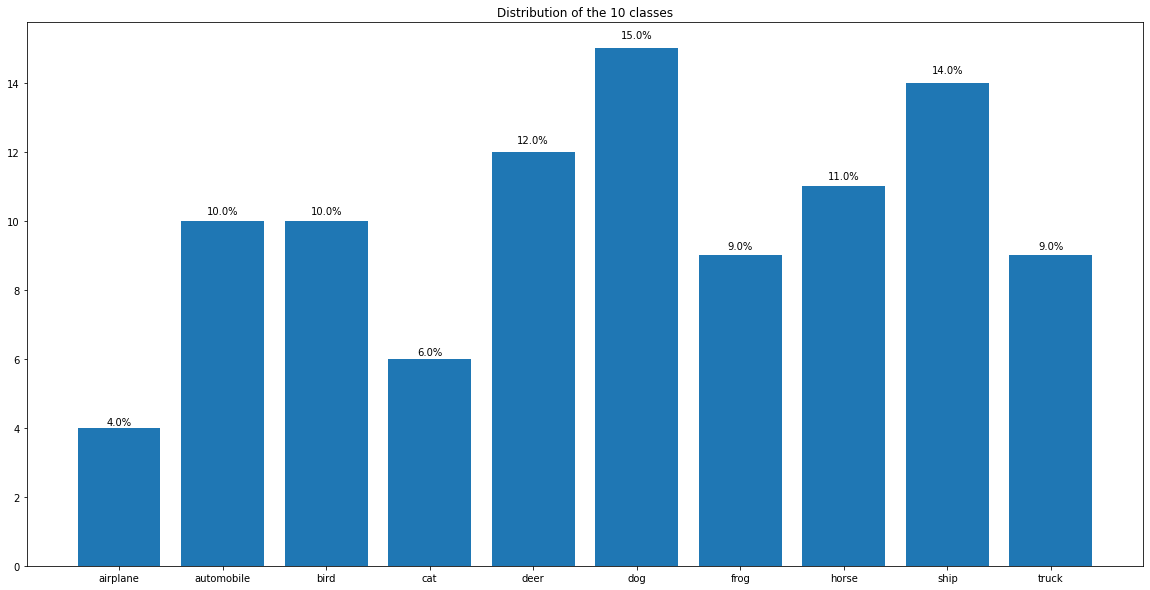

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


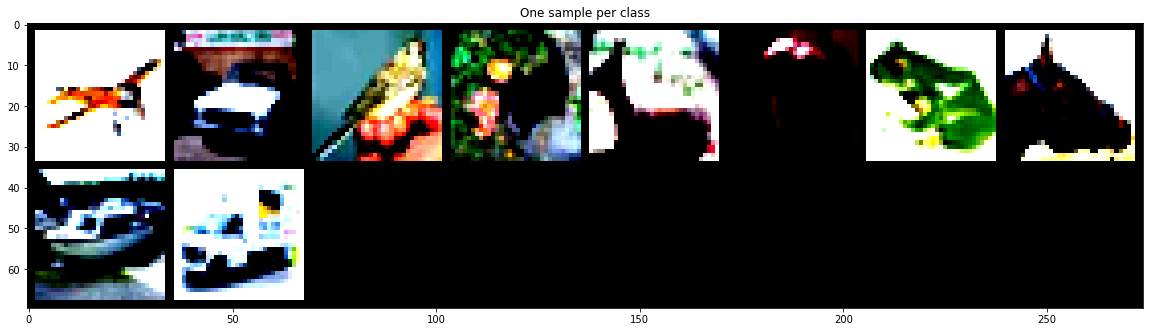

In [3]:
# The distribution of the 10 classes
hist = np.zeros(10)
for ytrue in Ytrue:
    unique, counts = np.unique(ytrue, return_counts=True)
    hist[unique] += counts

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Distribution of the 10 classes")
ax.bar(cifar10_classes, hist)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{round(height/(batch_size*num_batches) * 100, 1)}%', (x + width/2, y + height*1.02), ha='center')
plt.show()

# One image from each of the classes
sample_from_each_class = [None] * len(cifar10_classes)

for j in range(len(sample_from_each_class)):
    for i, batch in enumerate(X):
        for k, sample in enumerate(batch):
            if Ytrue[i, k] == j and sample_from_each_class[j] == None:
                sample_from_each_class[j] = sample.unsqueeze(0)
                
images = torch.cat(sample_from_each_class, 0)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("One sample per class")
images = utils.make_grid(images)
plot_img(images)

**Note:** 
The clipping warning happens because of the normalization in the preprocessing of the images. The exact values used for the normalization were taken from the original codebase of the model. What is depicted in the images can become harder to recognize for humans because of this, but normalizing the data is important for the model performance.

# Analysis of the model

In order to analyze the model we need to create an instace of ResNet44 and load in the checkpoint obtained from the code repository.

In [4]:
resnet44model = PytorchModel(resnet.resnet44(), {"checkpoint": resnet.checkpoint, "remove_prefix": "module."})

Next we can use an instance of `PyTorchNNMulticlassifier`, which implements the interface `NNModelInterface` that allows us to work with arbitrary neural networks.

But in PyTorch the model, optimizer (e.g. Stocahstic Gradient Descent) and loss (e.g. CrossEntropyLoss) are separate entities. Also the model checkpoint has no information about the optimizer or loss function. This means that we have to look into the training code to see which optimizer and loss was used and instantiate them manually.

In [5]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet44model.get_parameters(), lr=0.1) # the learning rate used in the codebase was 0.1

model = PyTorchNNMulticlassifier(resnet44model.model(), optimizer, loss_function)

## Functionality Analysis

We will now calculate the standard binary accuracy, balanced accuracy and weighted F1 metrics.

In [6]:
functionality_analysis = FunctionalityAnalysis(len(cifar10_classes))
functionality_results = functionality_analysis(model, [X, Ytrue])

print("Accuracy:          " + str(round(functionality_results["accuracy"], 3)))
print("Balanced Accuracy: " + str(round(functionality_results["balanced_accuracy"], 3)))
print("WeightedF1:        " + str(round(functionality_results["weightedF1"], 3)))

Accuracy:          0.956
Balanced Accuracy: 0.878
WeightedF1:        0.78


## Robustness Analysis

In this section we will conduct a robustness analysis by adversarial attacks using the *fast gradient sign method*.

FGSM works by taking a single input (in our model it is a mini-batch), doing a single forward step and a single backward step. The backward step calculates the gradient that the loss function produces. The sign of this gradient is used to produce an image that is the original input "nudged" a little in the direction of the gradient. This "reverses" the effect of the learned weights, which minimize the error (which is done by gradient descent), by maximizing the loss function. The amount by how much the original image is nudged is determined through `epsilon`.

In [7]:
robustness_analysis = RobustnessAnalysis(FGSMAttack(), len(cifar10_classes))
epsilon = [0.003, 0.007,  0.009, 0.01, 0.013, 0.017, 0.03, 0.05, 0.07, 0.1]
stats_attacked = np.ndarray((len(epsilon), 3))
for i, eps in enumerate(epsilon):
    robustness_analysis.set_attack_params({"eps": eps})
    result = robustness_analysis(model, [X, Ytrue])
    stats_attacked[i, :] = (result["accuracy"], result["balanced_accuracy"], result["weightedF1"])
    robustness_analysis.reset()

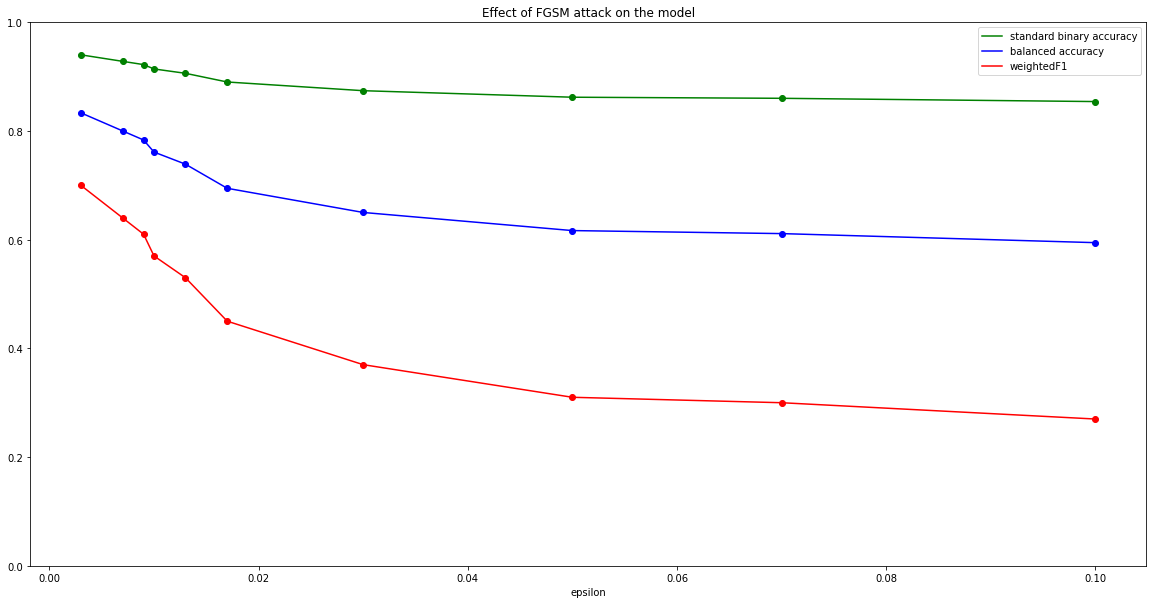

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(epsilon, stats_attacked[:, 0], 'go')
plt.plot(epsilon, stats_attacked[:, 0], '-g', label="standard binary accuracy")
plt.plot(epsilon, stats_attacked[:, 1], 'bo')
plt.plot(epsilon, stats_attacked[:, 1], '-b', label="balanced accuracy")
plt.plot(epsilon, stats_attacked[:, 2], 'ro')
plt.plot(epsilon, stats_attacked[:, 2], '-r', label="weightedF1")

ax.set_title("Effect of FGSM attack on the model")
ax.set_ylim(0.0, 1.0)
ax.set_xlabel("epsilon")
plt.legend()
plt.show()

**Note:**
The standard binary accuracy seems to be uneffected by the FGSM attack. The reason for this is that this metric isn't that useful in the context of multi-class classification. The true negatives (TN) of the confusion matrix dominate the true positives (TP), false positives (FP) and false negatives (FN) the more classes there are, because TN = (C-1) * TP, with C being the number of classes. The formula for computing the standard binary accuracy is (TP + TN) / (TP + TN + FP + FN). In our case we have 10 classes, so for every true positive there are 9 true negatives.

